# Quantum NN Regression: Sin

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math

print(tf.__version__)

2.3.0


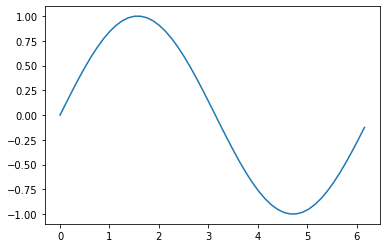

In [3]:
data_points = 50
train_x = np.array([p for p in np.arange(0, 2*math.pi, (2*math.pi / data_points))])
train_labels = np.array([math.sin(a) for a in train_x])

test_x = train_x.copy()
test_labels = train_labels.copy()

plt.plot(train_x,train_labels);

In [4]:
train_x.shape

(50,)

In [5]:
train_labels

array([ 0.00000000e+00,  1.25333234e-01,  2.48689887e-01,  3.68124553e-01,
        4.81753674e-01,  5.87785252e-01,  6.84547106e-01,  7.70513243e-01,
        8.44327926e-01,  9.04827052e-01,  9.51056516e-01,  9.82287251e-01,
        9.98026728e-01,  9.98026728e-01,  9.82287251e-01,  9.51056516e-01,
        9.04827052e-01,  8.44327926e-01,  7.70513243e-01,  6.84547106e-01,
        5.87785252e-01,  4.81753674e-01,  3.68124553e-01,  2.48689887e-01,
        1.25333234e-01, -3.21624530e-16, -1.25333234e-01, -2.48689887e-01,
       -3.68124553e-01, -4.81753674e-01, -5.87785252e-01, -6.84547106e-01,
       -7.70513243e-01, -8.44327926e-01, -9.04827052e-01, -9.51056516e-01,
       -9.82287251e-01, -9.98026728e-01, -9.98026728e-01, -9.82287251e-01,
       -9.51056516e-01, -9.04827052e-01, -8.44327926e-01, -7.70513243e-01,
       -6.84547106e-01, -5.87785252e-01, -4.81753674e-01, -3.68124553e-01,
       -2.48689887e-01, -1.25333234e-01])

# Build Model
We need to ensure that it is non-linear since the xor problem is nonlinear.

We implement a quantum layer from https://towardsdatascience.com/integrating-tensorflow-and-qiskit-for-quantum-machine-learning-7fa6b14d5294

In [6]:
from qiskit.aqua.operators import Z, Y, X
from qiskit.aqua.operators import StateFn
from qiskit.circuit import QuantumRegister, QuantumCircuit

QUBITS = 10
operatorZ = Z ^ Z ^ Z ^ Z
operatorX = X ^ X ^ X ^ X
operatorY = Y ^ Y ^ Y ^ Y

def quantum_layer(initial_parameters):
    # expecting parameters to be a numpy array
    quantumRegister = QuantumRegister(QUBITS)
    quantumCircuit = QuantumCircuit(quantumRegister)
    
    quantumCircuit.h(range(10))

    for i in range(len(initial_parameters)):
        quantumCircuit.ry(initial_parameters[i] * np.pi, i)
   
    psi = StateFn(quantumCircuit)
    
    # two ways of doing the same thing
    expectationX = (~psi @ operatorX @ psi).eval()
    expectationZ = psi.adjoint().compose(operatorZ).compose(psi).eval().real
    expectationY = (~psi @ operatorY @ psi).eval()
    
    expectationZ = np.abs(np.real(expectationZ))
    expectations = [expectationX, expectationY, expectationZ, 
                    expectationX + expectationY + expectationZ] 

    return np.array(expectations)

Integrate quantum layer into keras layer

In [7]:
class Linear(tf.keras.layers.Layer):
    def __init__(self, batch_size=64, units=4,**kwargs):
        super(Linear, self).__init__(**kwargs)  

    def get_config(self):
        config = super(Linear, self).get_config()
        return config

    def call(self, inputs):
        
        if(tf.executing_eagerly()):
            print("Yes!")
            final_output = []
            for i in range(inputs.shape[0]):
                pred = quantum_layer(inputs[i].numpy())
                final_output.append(list(pred))
            return tf.convert_to_tensor(final_output)
        return inputs

Put in our new quantum linear layer

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    Linear(),
    tf.keras.layers.Dense(10, activation='relu'),
    Linear(),
    tf.keras.layers.Dense(10, activation='relu'),
    Linear(),
    tf.keras.layers.Dense(10, activation='relu'),
    Linear(),
    tf.keras.layers.Dense(1)
])

In [9]:
# must be true
tf.executing_eagerly()

True

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss= tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [11]:
model.fit(train_x, train_labels, epochs=10000, verbose=0)

In [12]:
preds = model.predict(test_x)

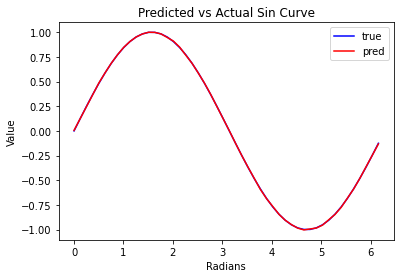

In [13]:
plt.plot(test_x, test_labels, c='blue', label='true')
plt.plot(test_x, preds, c='red', label='pred')
plt.title('Predicted vs Actual Sin Curve')
plt.ylabel('Value')
plt.xlabel('Radians')
plt.legend();